<a href="https://colab.research.google.com/github/ravi72munde/scala-spark-cab-rides-predictions/blob/Ravi/Cab_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS 3000 - Final Project
# Project Name: 

**Student Name**: [Tianhao Gao,Yuhan Wang, Yi Gu, Yige Sun ]

**Date**: [12/05]

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
sns.set() 
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

In [2]:
#load the data
weather_df = pd.read_csv('weather.csv')
cab_df = pd.read_csv('cab_rides.csv')

In [3]:
cab_df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [4]:
weather_df.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [5]:
#handle missing data -- imputation
weather_df['rain'] = weather_df['rain'].fillna(0)

In [6]:
cab_df.loc[cab_df['price'].isna(), 'price'] = 16.5

In [7]:
#Let's now convert the fields to a suitable data type
weather_df['location'] = weather_df['location'].astype('string')

In [8]:
cab_df['cab_type'] = cab_df['cab_type'].astype('string')
cab_df['destination'] = cab_df['destination'].astype('string')
cab_df['source'] = cab_df['source'].astype('string')
cab_df['price'] = cab_df['price'].astype(float)
cab_df['id'] = cab_df['id'].astype('string')
cab_df['product_id'] = cab_df['product_id'].astype('string')
cab_df['name'] = cab_df['name'].astype('string')

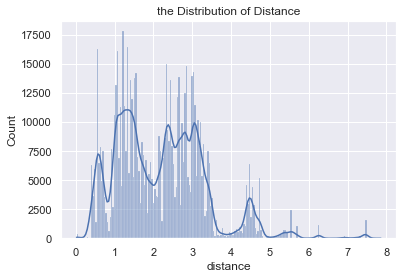

In [9]:
sns.histplot(data=cab_df, x='distance', kde=True)
plt.title('the Distribution of Distance')
plt.show()

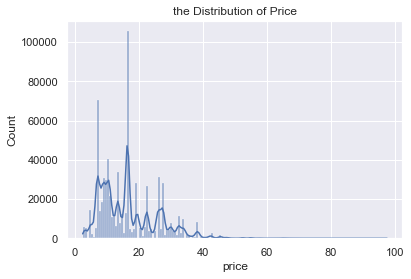

In [10]:
sns.histplot(data=cab_df, x='price', kde=True, bins=150)
plt.title('the Distribution of Price')
plt.show()

In [11]:
cab_df['date_time'] = pd.to_datetime(cab_df['time_stamp']/1000, unit='s')
weather_df['date_time'] = pd.to_datetime(weather_df['time_stamp'], unit='s')
cab_df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890000128
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.676999936
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-28 01:00:22.197999872
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749000192
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223000064


In [12]:
#merge the datasets to refelect same time for a location
cab_df['merge_date'] = cab_df.source.astype(str) +" - "+ cab_df.date_time.dt.date.astype("str") +" - "+ cab_df.date_time.dt.hour.astype("str")
weather_df['merge_date'] = weather_df.location.astype(str) +" - "+ weather_df.date_time.dt.date.astype("str") +" - "+ weather_df.date_time.dt.hour.astype("str")

In [13]:
weather_df.index = weather_df['merge_date']
merged_df = cab_df.join(weather_df,on=['merge_date'],rsuffix ='_w')
merged_df['price/distance'] = cab_df['price']/cab_df['distance']
merged_df = merged_df[pd.notnull(merged_df['date_time_w'])]
merged_df = merged_df[pd.notnull(merged_df['price'])]

In [14]:
cab_df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date_time,merge_date
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890000128,Haymarket Square - 2018-12-16 - 9
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.676999936,Haymarket Square - 2018-11-27 - 2
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-28 01:00:22.197999872,Haymarket Square - 2018-11-28 - 1
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749000192,Haymarket Square - 2018-11-30 - 4
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223000064,Haymarket Square - 2018-11-29 - 3


In [15]:
merged_df.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'date_time',
       'merge_date', 'temp', 'location', 'clouds', 'pressure', 'rain',
       'time_stamp_w', 'humidity', 'wind', 'date_time_w', 'merge_date_w',
       'price/distance'],
      dtype='object')

In [16]:
merged_df['name'].value_counts()

Black           101102
UberXL          100859
Black SUV       100795
Taxi            100679
WAV             100615
UberPool        100402
UberX           100105
Lyft             93886
Shared           93762
Lux              93562
Lux Black        93533
Lyft XL          93387
Lux Black XL     92988
Name: name, dtype: Int64

In [17]:
merged_df['price/distance']

0         11.363636
1         25.000000
1         25.000000
3         59.090909
4         20.454545
            ...    
693066    13.000000
693067     9.500000
693068    16.500000
693069    27.000000
693070    10.000000
Name: price/distance, Length: 1265675, dtype: float64

In [18]:
merged_df = merged_df[merged_df.surge_multiplier == 1]

In [19]:
X = merged_df[merged_df.name=='Lyft'][['temp','clouds', 'pressure','humidity', 'wind', 'rain']]

In [20]:
X.count()

temp        86136
clouds      86136
pressure    86136
humidity    86136
wind        86136
rain        86136
dtype: int64

In [21]:
y = merged_df[merged_df.name=='Lyft']['price/distance'] 

In [22]:
y.count()

86136

In [23]:
# X.reset_index(inplace=True)
# X = X.drop(columns=['index'])

In [24]:
X.head()

,temp,clouds,pressure,humidity,wind,rain
11,41.09,1.00,991.83,0.64,9.45,0.000
11,40.51,1.00,992.59,0.66,9.88,0.000
11,41.05,1.00,991.92,0.64,9.50,0.000
21,23.65,0.64,1006.82,0.54,16.19,0.000
33,48.34,0.99,1006.02,0.94,4.11,0.003


In [25]:
# #normalize X
# x = X
# x = preprocessing.normalize(x)
# X = pd.DataFrame(x, columns=X.columns)

In [26]:
# features = pd.get_dummies(X)

In [27]:
# features.columns

### Linear Regression

In [81]:
#split the data into training and test sets
X = merged_df[merged_df.name=='Lyft'][['temp','clouds', 'pressure','humidity', 'wind', 'rain']]
y = merged_df[merged_df.name=='Lyft']['price/distance']

X = X.copy()
y = y.copy()

# preprocess the dataset
X.reset_index(inplace=True)
X = X.drop(columns=['index'])

# #normalize X
# x = X
# x = preprocessing.normalize(x)
# X = pd.DataFrame(x, columns=X.columns)

In [82]:
# split the test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        test_size = 0.3, 
                       random_state = 7,
                                        )

X_train = X_train.copy()
X_test  = X_test.copy()


In [83]:
# #Linear regression
# x1 = X.copy()
# y1 = y.copy()
# # x1.reset_index(inplace=True)
# # x1 = x1.drop(columns=['index'])

# x1.to_numpy()
# y1.to_numpy()
# x1, y1 = np.array(x1), np.array(y1)



In [84]:
lr_model = LinearRegression(fit_intercept=True) #initialize the regression model
lr_model.fit(X_train, y_train)                  #fit the data to the model i.e. find the line of best fit

LinearRegression()

In [85]:
y_pred = lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred) #calculate mse

# Evaluate the Predictions
print('The mse of the model is: {}'.format(mse.round(2)))

The mse of the model is: 6.4


##### Evaluation
The linear regression might not fit in this model since there is no strong linear correlation showing up in the graph. 

### KNN Regression

In [31]:
#split the data into training and test sets
X = merged_df[merged_df.name=='Lyft'][['temp','clouds', 'pressure','humidity', 'wind', 'rain']]
y = merged_df[merged_df.name=='Lyft']['price/distance']

X = X.copy()
y = y.copy()

# preprocess the dataset
X.reset_index(inplace=True)
X = X.drop(columns=['index'])

#normalize X
x = X
x = preprocessing.normalize(x)
X = pd.DataFrame(x, columns=X.columns)

In [32]:
# split the test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        test_size = 0.3, 
                       random_state = 7,
                                        )

X_train = X_train.copy()
X_test  = X_test.copy()

In [33]:
#build the k-nn model, experiment with different values of k and plot the results

knn = KNeighborsRegressor(n_neighbors = 1000) #initialize the classifier and set the number of neighbors
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=1000)

In [34]:
# Use the trained model to predict based on test sets
pred=knn.predict(X_test) #make prediction on test set
mse = mean_squared_error(y_test,pred) #calculate mse

# Evaluate the Predictions
print('The mse of the model is: {}'.format(mse.round(2)))

The mse of the model is: 6.38


#### Hyperparameter tuning using GridSearchCV

In [35]:
knn = KNeighborsRegressor()
k_range = list(range(0, 1001, 100))
# k_range = list(range(1, 3))
k_range[0] = 1
param = dict(n_neighbors=k_range)

In [36]:
knn_grid = GridSearchCV(estimator = knn, param_grid=param, cv=5, return_train_score=True)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 100, 200, 300, 400, 500, 600, 700,
                                         800, 900, 1000]},
             return_train_score=True)

In [37]:
print(knn_grid.best_params_) #print the best parameters
print(round(knn_grid.best_score_,2))  #print the best score

{'n_neighbors': 100}
0.03


In [38]:
#KNN tried with the best value of n_neighbors
knn = KNeighborsRegressor(n_neighbors = 100) 
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=100)

In [39]:
# Use model to predict the value based on the test sets 
pred=knn.predict(X_test) #make prediction on test set
# Evaluate the accuracy by mean squared error
mse = mean_squared_error(y_test,pred) #calculate mse

# Evaluate the Predictions
print('The mse of the model is: {}'.format(mse.round(2)))

The mse of the model is: 6.13


###### Evaluation
From the Grid Search Cross Validation, the base estimator for KNN Regression would be 100. We use the model where estimator = 100 to predict on the test set. By calculating the mean squared error between test set and predicted set, the best mse value is 6.13, which still indicate that the model itself is not accurate enough. 


## Decision Tree Regression

In [40]:
#split the data into training and test sets
X = merged_df[merged_df.name=='Lyft'][['temp','clouds', 'pressure','humidity', 'wind', 'rain']]
y = merged_df[merged_df.name=='Lyft']['price/distance']

X = X.copy()
y = y.copy()

# preprocess the dataset
X.reset_index(inplace=True)
X = X.drop(columns=['index'])

#normalize X
x = X
x = preprocessing.normalize(x)
X = pd.DataFrame(x, columns=X.columns)

In [41]:
# #split the data into training and test sets
# X = merged_df[merged_df.name=='Lyft'][['temp','clouds', 'pressure','humidity', 'wind', 'rain']]
# y = merged_df[merged_df.name=='Lyft']['price/distance']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        test_size = 0.3, 
                       random_state = 7,
                                        )
X_train = X_train.copy()
X_test  = X_test.copy()

In [42]:
dt = DecisionTreeRegressor(random_state=7)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=7)

In [43]:
#predict the labels for the test set
y_pred   = dt.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(mse.round(2)))

The mse of the model is: 5.69


## Random Forest Regression

In [44]:
# Select feature and predict element from dataframe
X = merged_df[merged_df.name=='Lyft'][['temp','clouds', 'pressure','humidity', 'wind', 'rain']]
y = merged_df[merged_df.name=='Lyft']['price/distance']

X = X.copy()
y = y.copy()

# preprocess the dataset
X.reset_index(inplace=True)
X = X.drop(columns=['index'])

#normalize X
x = X
x = preprocessing.normalize(x)
X = pd.DataFrame(x, columns=X.columns)

In [45]:
#split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 7
                                                   )
X_train = X_train.copy()
X_test  = X_test.copy()

#### Select features

In [47]:
from sklearn.feature_selection import SelectFromModel

In [48]:
sel = SelectFromModel(RandomForestRegressor(random_state=7))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(random_state=7))

In [49]:
importance = sel.estimator_.feature_importances_.ravel()
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.2f' % (X.columns[i],v))

Feature: temp, Score: 0.23
Feature: clouds, Score: 0.10
Feature: pressure, Score: 0.21
Feature: humidity, Score: 0.08
Feature: wind, Score: 0.34
Feature: rain, Score: 0.04


#### Train using selected features

In [50]:
# Select feature and predict element from dataframe
X = merged_df[merged_df.name=='Lyft'][['temp','clouds', 'pressure', 'wind']]
y = merged_df[merged_df.name=='Lyft']['price/distance']

X = X.copy()
y = y.copy()

# preprocess the dataset
X.reset_index(inplace=True)
X = X.drop(columns=['index'])

#normalize X
x = X
x = preprocessing.normalize(x)
X = pd.DataFrame(x, columns=X.columns)

In [51]:
#split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 7
                                                   )
X_train = X_train.copy()
X_test  = X_test.copy()

###### Example Random Forest Regression when n_estimator = 200

In [55]:
rf = RandomForestRegressor(n_estimators = 200, random_state=7)
rf.fit(X_train, y_train.values.ravel())

RandomForestRegressor(n_estimators=200, random_state=7)

In [56]:
#predict the labels for the test set
y_pred   = rf.predict(X_test)

#print('The predicted birth weight is: {}'.format(y_pred))
mse = mean_squared_error(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(mse.round(2)))

The mse of the model is: 5.65


#### Hyperparameter tuning in Random Forest 

In [57]:
rf = RandomForestRegressor()
n_range = list(range(0, 1001, 200))
# k_range = list(range(1, 3))
n_range[0] = 1
param = dict(n_estimators=n_range)

In [58]:
rf_grid = GridSearchCV(estimator = rf, param_grid=param, cv=5, return_train_score=True)
rf_grid.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [1, 200, 400, 600, 800, 1000]},
             return_train_score=True)

In [59]:
print(rf_grid.best_params_) #print the best parameters
print(round(rf_grid.best_score_,2))  #print the best score

{'n_estimators': 800}
0.1


In [60]:
rf = RandomForestRegressor(n_estimators = 800, random_state=7)
rf.fit(X_train, y_train.values.ravel())

RandomForestRegressor(n_estimators=800, random_state=7)

In [61]:
#predict the labels for the test set
y_pred   = rf.predict(X_test)

#print('The predicted birth weight is: {}'.format(y_pred))
mse = mean_squared_error(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(mse.round(2)))

The mse of the model is: 5.65


###### Evaluation
From the Grid Search Cross Validation, the best estimator for Random Forest Regression would be 200. We use the model where estimator = 100 to predict on the test set. By calculating the mean squared error between test set and predicted set, the best mse value is 6.13, which still indicate that the model itself is not accurate enough. 
